# Problem Statement: Longest Streak in a Coin Toss  

Imagine you are flipping a fair coin $K$ times, recording the outcome as a sequence of **heads** (`0`) and **tails** (`1`). What is the probability $p(K, N)$ that there is **no** streak of at least $N$ consecutive heads or at least $N$ consecutive tails in the sequence?

## Input Format  
You are given two integers:  
- $K$ ($1 < K \leq 1000$): The number of times you flip the coin.  
- $N$ ($1 \leq N \leq K$): The minimum streak length that we want to **avoid**.  

## Output Format  
Print a single floating-point number representing the probability that no streak of length $N$ or more appears in the sequence of length $K$. The answer should be accurate to at least **10 decimal places**.

## Examples

### Example 1  
**Input:** $5, \; 2$ \
**Output:** $0.0625$  
**Explanation:** If you flip a coin 5 times, there are $2^5 = 32$ possible sequences. Only 2 **do not** contain `00` or `11`: `01010` and `10101`.
So, $p(5, 2) = \frac{2}{32} = 0.0625$.

### Example 2 
**Input:** $10, \; 4$ \
**Output:** $0.53515625$  
**Explanation:** If you flip a coin 10 times, there are $2^{10} = 1024$ possible sequences. Among them, 548 **do not** contain a streak of 4 or more heads or tails (e.g. `0011101101`, but not `0011110101`).
So, $p(10, 4) = \frac{548}{1024} = 0.53515625$.

## Notes  
A brute-force approach that checks all $2^N$ sequences is infeasible for large $K$. Instead, a dynamic programming approach is required to efficiently count valid sequences.  


In [1]:
import random
import itertools

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [2]:
def n_random_bits(k):
    return "".join(random.choices("01", k=k))


def prob_valid_string_sim(k: int, n: int, n_runs: int) -> float:
    no_substrings = 0
    ONES = "1" * n
    ZEROS = "0" * n
    for _ in range(n_runs):
        s = n_random_bits(k)
        if ONES not in s and ZEROS not in s:
            no_substrings += 1
    return no_substrings / n_runs


def num_valid_strings_brute_force(k: int, n: int) -> float:
    """Calculates the total number of k-length strings that
    do not contain any such repeated n-length substrings."""
    no_substrings = 0
    ONES = "1" * n
    ZEROS = "0" * n
    for digits in itertools.product("01", repeat=k):
        s = "".join(digits)
        if ONES not in s and ZEROS not in s:
            no_substrings += 1
    return no_substrings


def prob_valid_string_brute_force(k: int, n: int) -> float:
    return num_valid_strings_brute_force(k, n) / 2**k

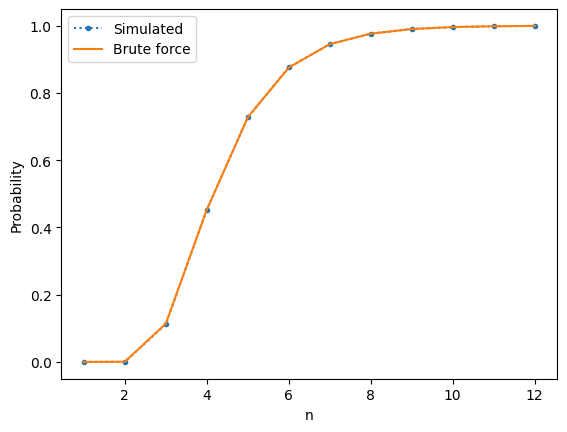

In [3]:
K_VALUE = 12
n_values = list(range(1, K_VALUE + 1))
simulated_probabilities = [prob_valid_string_sim(K_VALUE, n, 100_000) for n in n_values]
brute_force_probabilities = [prob_valid_string_brute_force(K_VALUE, n) for n in n_values]

plt.plot(n_values, simulated_probabilities, '.:', label="Simulated")
plt.plot(n_values, brute_force_probabilities, label="Brute force")
plt.xlabel("n")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Dynamic Programming Approach

Let us consider all binary strings of length $K$ that start with `0` (from symmetry, there is the same number of those that start with `1` and have all other bits flipped as well) and are valid (that is, they do not contain the repeated substrings of length $N$: `00...0` or `11...1`).

For the sake of example, let $K=9$ and $N=4$. We now build a tree, where each node is the character `0`/`1`, and the paths from the root to the leaves form valid sequences.

<img src="images/forbidden-repeated-substrings.png" alt="solution" width="50%"/>

Each node is characterized by two numbers:
- the remaining length of the string (the first node has this value equal $K-1$) — subscript, in red;
- the current streak length of this exact character — superscript, in purple.

Now, consider the function $r_N(k, i)$ that counts the number of ways to validly (no repeated substrings of length $N$) complete the remaining $k$ characters (corresponds to the red subscript in the tree above) given that the current streak length is $i$ (purple superscript). In other words, this is the number of leaves of the node with the given characteristics $k$ and $i$.

For example, $r_3(3, 1) = 5$ — the total number of ways to complete the string `1xxx` such that there are no `000` or `111`; all of them are: `1001`, `1010`, `1011`, `1100`, `1101`.

Let us build the recurrence relations for the dynamical solution.

First, 
$$ r_N(0, \cdot) = 1 $$ 
— the value at the leaves which we would like to count.

Then, if the current streak is not too long*, we can choose either character, and the respective node has two children (for example, the top node $1^2_6$). Moreover, we either add the same character, thus incrementing $i$, or a different character, thus resetting $i$ to $1$. Of course, $k$ is decreased by one from parent to child (we add one more character, thus decreasing the number of remaining characters by one).

Then, 
$$ r_N(k, i) = r(k-1, 1) + r(k-1, i+1). $$

Now we address the "not too long" condition. A node has two children if the current streak $i$ is less than $N-1$. So, we require $ i < N-1 $.

Otherwise, if $i=N-1$, we can only add a different from the current streak character and thus reset $i$ to $1$:
$$ r_N(k, i) = r(k-1, 1). $$

Finally, we obtain

$$
r_N(k, i) =
\begin{align*}
\begin{cases}
r(k-1, 1) + r(k-1, i+1) \;\;\;\; &i < N-1, \\
r(k-1, 1) &i = N-1, \\
1 &k=0.
\end{cases}
\end{align*}
$$

In order to count all the leaves in the tree above, we need to calculate $r_N(K-1, 1)$ (start with the character `0`; current streak length is $1$; $K-1$ characters remaining). However, the total number of such strings would be equal to $2\cdot r_N(K-1, 1)$ since we would have a second tree, topologically equivalent to this one, which has all the characters fliped (`0` $\leftrightarrow$ `1`).

In [4]:
from functools import cache


@cache
def r(k, n, i):
    if k == 0:
        return 1
    if i == n - 1:
        return r(k - 1, n, 1)
    return r(k - 1, n, 1) + r(k - 1, n, i + 1)


def num_valid_strings_dyn(k, n):
    return 2 * r(k - 1, n, 1)


def prob_valid_string_dyn(k, n) -> float:
    return num_valid_strings_dyn(k, n) / 2**k

In [5]:
# compare the brute force and dynamical solutions
for k_value in range(5, 10):
    for n_value in range(2, k_value):
        print(
            f"k={k_value}, n={n_value}; "
            f"brute force: {num_valid_strings_brute_force(k_value, n_value)}, dynamical: {num_valid_strings_dyn(k_value, n_value)}"
        )

k=5, n=2; brute force: 2, dynamical: 2
k=5, n=3; brute force: 16, dynamical: 16
k=5, n=4; brute force: 26, dynamical: 26
k=6, n=2; brute force: 2, dynamical: 2
k=6, n=3; brute force: 26, dynamical: 26
k=6, n=4; brute force: 48, dynamical: 48
k=6, n=5; brute force: 58, dynamical: 58
k=7, n=2; brute force: 2, dynamical: 2
k=7, n=3; brute force: 42, dynamical: 42
k=7, n=4; brute force: 88, dynamical: 88
k=7, n=5; brute force: 112, dynamical: 112
k=7, n=6; brute force: 122, dynamical: 122
k=8, n=2; brute force: 2, dynamical: 2
k=8, n=3; brute force: 68, dynamical: 68
k=8, n=4; brute force: 162, dynamical: 162
k=8, n=5; brute force: 216, dynamical: 216
k=8, n=6; brute force: 240, dynamical: 240
k=8, n=7; brute force: 250, dynamical: 250
k=9, n=2; brute force: 2, dynamical: 2
k=9, n=3; brute force: 110, dynamical: 110
k=9, n=4; brute force: 298, dynamical: 298
k=9, n=5; brute force: 416, dynamical: 416
k=9, n=6; brute force: 472, dynamical: 472
k=9, n=7; brute force: 496, dynamical: 496
k=9,

Probabilities: Simulation vs. Brute force vs. Dynamical Solution

In [6]:
K_VALUE = 20

n_values = list(range(2, 16))

brute_force_probabilities = [
    prob_valid_string_brute_force(K_VALUE, n) for n in n_values
]
recursive_probabilities = [prob_valid_string_dyn(K_VALUE, n) for n in n_values]
simulated_probabilities = [
    prob_valid_string_sim(K_VALUE, n, 1_000) for n in n_values
]


fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=n_values, y=brute_force_probabilities, mode="lines", name="Brute force"
    )
)
fig.add_trace(
    go.Scatter(x=n_values, y=recursive_probabilities, mode="lines", name="Recursive")
)
fig.add_trace(
    go.Scatter(x=n_values, y=simulated_probabilities, mode="markers", name="Simulated")
)
fig.update_layout(
    title="Probability of no n-length substrings in k-length string",
    xaxis_title="n",
    yaxis_title="Probability",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    template="plotly_dark",
)
fig.show()


Values depending on the sequence length $K$.

In [7]:
K_VALUES = 10, 50, 100, 200, 500


fig = go.Figure()
for K in K_VALUES:
    n_vals = list(range(2, 20))

    probs = [prob_valid_string_dyn(K, n) for n in n_vals]
    fig.add_trace(go.Scatter(x=n_vals, y=probs, mode="lines+markers", name=f"K={K}"))

fig.update_layout(
    title="Probability of no repeated N-length substrings in a K-length string",
    xaxis_title="N",
    yaxis_title="Probability",
    legend_title="total length K",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    template="plotly_dark",
)

fig.show()
